In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
from typing import List, Tuple, Dict, Union, NoReturn
from urllib.parse import urlparse
import random

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine

In [4]:
import matplotlib.pyplot as plt

## Connect to database and query data

In [5]:
PROJECT_SRC = '/workspace/src'
os.chdir(PROJECT_SRC)
    
SQLALCHEMY_DATABASE_URI='sqlite:///../data/database.db'
engine = create_engine(SQLALCHEMY_DATABASE_URI, echo=False)

In [6]:
# get recent data and update database
!python get_data.py

Database is up to date - no data to gather


In [7]:
with engine.connect() as conn:
    
    join_txt='''
    SELECT 
        g.dttm, 
        wind, 
        solar, 
        load_mwh,
        price
    FROM GENERATION as g
    INNER JOIN
    LOAD as l
    ON g.dttm = l.dttm
    INNER JOIN
    PRICE as p
    ON g.dttm = p.dttm
    
    '''
    
    data = pd.read_sql(join_txt, engine)
    
data


,dttm,wind,solar,load_mwh,price
0,2020-01-01 01:00:00.000000,12443.0,0.0,16368.09,12.52
1,2020-01-01 02:00:00.000000,12338.8,0.0,15948.21,12.35
2,2020-01-01 03:00:00.000000,12075.4,0.0,15586.64,12.06
3,2020-01-01 04:00:00.000000,11957.9,0.0,15336.74,11.97
4,2020-01-01 05:00:00.000000,12012.6,0.0,15288.27,12.37
...,...,...,...,...,...
21451,2022-06-12 20:00:00.000000,2063.7,76.1,19667.93,89.24
21452,2022-06-12 21:00:00.000000,2399.4,10.5,19430.92,82.09
21453,2022-06-12 22:00:00.000000,3022.2,0.0,19105.11,78.08
21454,2022-06-12 23:00:00.000000,3157.1,0.0,18073.86,62.78


In [8]:
data.dttm = pd.to_datetime(data.dttm)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21456 entries, 0 to 21455
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dttm      21456 non-null  datetime64[ns]
 1   wind      21455 non-null  float64       
 2   solar     21454 non-null  float64       
 3   load_mwh  21456 non-null  float64       
 4   price     21456 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 838.2 KB


In [10]:
# find any gaps in timeseries
all_hours = pd.DataFrame({'dttm':pd.date_range(data.dttm.min(), data.dttm.max(), freq='H')})
data = all_hours.merge(data, on='dttm', how='left')

In [11]:
data.describe()

,wind,solar,load_mwh,price
count,21455.000000,21454.000000,21456.000000,21456.000000
mean,7433.248338,43.381742,16686.592553,29.277143
std,4118.355123,67.603648,2423.161019,28.798109
min,11.500000,0.000000,10772.120000,-57.560000
25%,3854.900000,0.000000,14930.637500,16.090000
50%,7263.400000,0.500000,16507.295000,22.000000
75%,10967.900000,74.275000,18187.480000,35.040000
max,17027.700000,405.500000,25715.570000,888.140000


In [12]:
data.isna().sum()

dttm        0
wind        1
solar       2
load_mwh    0
price       0
dtype: int64

In [13]:
data.fillna(method='ffill', inplace=True)

In [14]:
data.isna().sum()

dttm        0
wind        0
solar       0
load_mwh    0
price       0
dtype: int64

In [15]:
data.set_index('dttm', inplace=True)

In [16]:
data

,wind,solar,load_mwh,price
dttm,,,,
2020-01-01 01:00:00,12443.0,0.0,16368.09,12.52
2020-01-01 02:00:00,12338.8,0.0,15948.21,12.35
2020-01-01 03:00:00,12075.4,0.0,15586.64,12.06
2020-01-01 04:00:00,11957.9,0.0,15336.74,11.97
2020-01-01 05:00:00,12012.6,0.0,15288.27,12.37
...,...,...,...,...
2022-06-12 20:00:00,2063.7,76.1,19667.93,89.24
2022-06-12 21:00:00,2399.4,10.5,19430.92,82.09
2022-06-12 22:00:00,3022.2,0.0,19105.11,78.08


<AxesSubplot:>

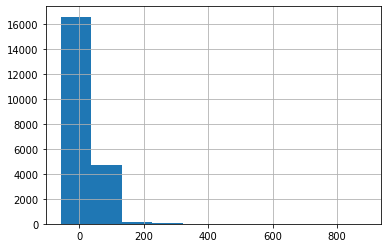

In [17]:
data.price.hist()

In [18]:
np.percentile(data.price, (0.5, 99.5));

In [19]:
MAX_PRICE = 175
data.loc[data.price > MAX_PRICE, 'price'] = MAX_PRICE

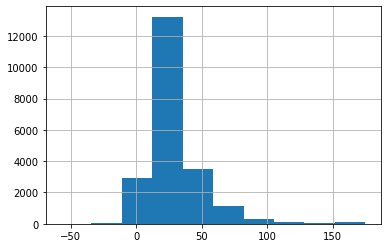

In [20]:
data.price.hist();

In [21]:
data.describe()

,wind,solar,load_mwh,price
count,21456.000000,21456.000000,21456.000000,21456.000000
mean,7433.177372,43.377713,16686.592553,28.711711
std,4118.272265,67.601785,2423.161019,22.919600
min,11.500000,0.000000,10772.120000,-57.560000
25%,3855.250000,0.000000,14930.637500,16.090000
50%,7263.150000,0.500000,16507.295000,22.000000
75%,10967.700000,74.225000,18187.480000,35.040000
max,17027.700000,405.500000,25715.570000,175.000000


## Data scaling

In [22]:
# define lookback and lookforward periods for 
# gathering training/test sets and creating
# t_idx: a data frame time indexes for the 
# lookback and lookforward periods
LOOKBACK = 23 
LOOKFORWARD = 24

In [23]:
# get training and test indexes
np.random.seed(42)
TRAIN_IDX = np.random.choice(range(data.shape[0]-LOOKBACK-LOOKFORWARD), size=int(0.8*len(data)), replace=False)
TRAIN_IDX

array([ 1201,  5186, 12157, ..., 10623, 17377, 12852])

In [24]:
TEST_IDX = np.setdiff1d(range(data.shape[0]-LOOKBACK-LOOKFORWARD),TRAIN_IDX)
TEST_IDX

array([    9,    11,    13, ..., 21401, 21406, 21408])

### Gather scaler metrics

In [25]:
scaler = {}
scaler['means'] = data.iloc[TRAIN_IDX,:].mean()
scaler['means']

wind         7434.147396
solar          43.101194
load_mwh    16690.180474
price          28.596930
dtype: float64

In [26]:
scaler['sd'] = data.iloc[TRAIN_IDX,:].std()
scaler['sd']

wind        4110.703737
solar         67.509622
load_mwh    2424.076812
price         22.819102
dtype: float64

### define scaling functions

In [27]:
def scale_data(
    data: pd.core.frame.DataFrame, 
    scaler: Dict[str, pd.core.series.Series],
) -> pd.core.frame.DataFrame:
    
    return ((data - scaler['means'])/scaler['sd'])

data_scaled = scale_data(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21456.000000,21456.000000,21456.000000,21456.000000
mean,-0.000236,0.004096,-0.001480,0.005030
std,1.001841,1.001365,0.999622,1.004404
min,-1.805688,-0.638445,-2.441367,-3.775649
25%,-0.870629,-0.638445,-0.725861,-0.548090
50%,-0.041598,-0.631039,-0.075445,-0.289097
75%,0.859598,0.461028,0.617678,0.282354
max,2.333798,5.368106,3.723228,6.415812


In [28]:
def unscale_data(
    data_scaled: pd.core.frame.DataFrame, 
    scaler: Dict[str, pd.core.series.Series],
) -> pd.core.frame.DataFrame:
    
    return data_scaled*scaler['sd'] + scaler['means']

In [29]:
data = unscale_data(data_scaled, scaler)
data.describe()

,wind,solar,load_mwh,price
count,21456.000000,21456.000000,21456.000000,21456.000000
mean,7433.177372,43.377713,16686.592553,28.711711
std,4118.272265,67.601785,2423.161019,22.919600
min,11.500000,0.000000,10772.120000,-57.560000
25%,3855.250000,0.000000,14930.637500,16.090000
50%,7263.150000,0.500000,16507.295000,22.000000
75%,10967.700000,74.225000,18187.480000,35.040000
max,17027.700000,405.500000,25715.570000,175.000000


### Create scaling data set for use in modeling

In [30]:
data_scaled = scale_data(data, scaler)
data_scaled.describe()

,wind,solar,load_mwh,price
count,21456.000000,21456.000000,21456.000000,21456.000000
mean,-0.000236,0.004096,-0.001480,0.005030
std,1.001841,1.001365,0.999622,1.004404
min,-1.805688,-0.638445,-2.441367,-3.775649
25%,-0.870629,-0.638445,-0.725861,-0.548090
50%,-0.041598,-0.631039,-0.075445,-0.289097
75%,0.859598,0.461028,0.617678,0.282354
max,2.333798,5.368106,3.723228,6.415812


## Create `t_idx` dataframe
`t_idx` has `t_start`, `t_now`, and `t_end` columns which define the start and end points of a sample based on the `LOOKBACK` and `LOOKFORWARD` windows.  This data frame is used in the data loader to produce samples.

In [31]:
def create_t_idx(
    data: pd.core.frame.DataFrame, 
    LOOKBACK: int, 
    LOOKFORWARD: int
) -> pd.core.frame.DataFrame:
    
    t_idx = pd.DataFrame()
    t_idx['t_start'] = data.index
    t_idx['t_now'] = data.index.shift(LOOKBACK, freq='H')
    t_idx['t_end'] = data.index.shift(LOOKBACK+LOOKFORWARD, freq='H')
    t_idx = t_idx[t_idx.t_end <= t_idx.t_start.max()]
    return t_idx

In [32]:
t_idx = create_t_idx(data, LOOKBACK, LOOKFORWARD)
t_idx

,t_start,t_now,t_end
0,2020-01-01 01:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00
1,2020-01-01 02:00:00,2020-01-02 01:00:00,2020-01-03 01:00:00
2,2020-01-01 03:00:00,2020-01-02 02:00:00,2020-01-03 02:00:00
3,2020-01-01 04:00:00,2020-01-02 03:00:00,2020-01-03 03:00:00
4,2020-01-01 05:00:00,2020-01-02 04:00:00,2020-01-03 04:00:00
...,...,...,...
21404,2022-06-10 21:00:00,2022-06-11 20:00:00,2022-06-12 20:00:00
21405,2022-06-10 22:00:00,2022-06-11 21:00:00,2022-06-12 21:00:00
21406,2022-06-10 23:00:00,2022-06-11 22:00:00,2022-06-12 22:00:00
21407,2022-06-11 00:00:00,2022-06-11 23:00:00,2022-06-12 23:00:00


## Test getting data from time indexes

In [33]:
# test_idx = 21118
test_idx = 0
t_idx.iloc[test_idx,:]

t_start   2020-01-01 01:00:00
t_now     2020-01-02 00:00:00
t_end     2020-01-03 00:00:00
Name: 0, dtype: datetime64[ns]

In [34]:
# get dataframe with historical and future timeseries values
# i.e. historical values from t_start:t_now and 
# future values from t_now:t_end
# in production future values would come from forecasts 
# but actuals will be used for training
hist_future_cols = ['wind', 'solar', 'load_mwh']
hist_future = data_scaled.loc[t_idx.t_start[test_idx]:t_idx.t_end[test_idx], hist_future_cols]
hist_future

,wind,solar,load_mwh
dttm,,,
2020-01-01 01:00:00,1.218490,-0.638445,-0.132871
2020-01-01 02:00:00,1.193142,-0.638445,-0.306084
2020-01-01 03:00:00,1.129065,-0.638445,-0.455242
2020-01-01 04:00:00,1.100481,-0.638445,-0.558332
2020-01-01 05:00:00,1.113788,-0.638445,-0.578328
2020-01-01 06:00:00,1.108801,-0.638445,-0.550519
2020-01-01 07:00:00,1.040127,-0.638445,-0.456277
2020-01-01 08:00:00,0.912801,-0.638445,-0.382769
2020-01-01 09:00:00,0.776352,-0.638445,-0.273506


In [35]:
# get dataframe with historical timeseries values
label_cols = ['price']
hist = data_scaled.loc[t_idx.t_start[test_idx]:t_idx.t_now[test_idx], label_cols]
hist

,price
dttm,
2020-01-01 01:00:00,-0.704538
2020-01-01 02:00:00,-0.711988
2020-01-01 03:00:00,-0.724697
2020-01-01 04:00:00,-0.728641
2020-01-01 05:00:00,-0.711112
2020-01-01 06:00:00,-0.610757
2020-01-01 07:00:00,-0.566496
2020-01-01 08:00:00,-0.619522
2020-01-01 09:00:00,-0.571755


In [36]:
# get dataframe with future timeseries label values
# this is what we're trying to predict
label_cols = ['price']
label = data_scaled.loc[(t_idx.t_now[test_idx]+pd.DateOffset(hours=1)):t_idx.t_end[test_idx], label_cols]
label

,price
dttm,
2020-01-02 01:00:00,-0.592352
2020-01-02 02:00:00,-0.657209
2020-01-02 03:00:00,-0.687886
2020-01-02 04:00:00,-0.722506
2020-01-02 05:00:00,-0.758440
2020-01-02 06:00:00,-0.725573
2020-01-02 07:00:00,-0.665536
2020-01-02 08:00:00,-0.712865
2020-01-02 09:00:00,-0.714179


In [37]:
# function to create tabular data from t_now index
# this will consist of one hot encoding for timestamp variables
def create_tabular_data(
    t_now: pd._libs.tslibs.timestamps.Timestamp
) -> pd.core.frame.DataFrame:
    
    hours = pd.DataFrame({f'hour_{i}':1*(t_now.hour == i) for i in range(24)}, index=[0])
    dayofweek = pd.DataFrame({f'dayofweek_{i}':1*(t_now.dayofweek == i) for i in range(7)}, index=[0])
    month = pd.DataFrame({f'month_{i}':1*(t_now.month == i) for i in range(1, 13)}, index=[0])
    # week = pd.DataFrame({f'week_{i}':1*(t_now.isocalendar()[1] == i) for i in range(1, 54)}, index=[0])
    day = pd.DataFrame({f'day_{i}':1*(t_now.day == i) for i in range(1,32)}, index=[0])
        
        
    return pd.concat([day, month, dayofweek, hours], axis=1)

In [38]:
tabular_data = create_tabular_data(t_idx.t_now[test_idx])
tabular_data.transpose()

,0
day_1,0
day_2,1
day_3,0
day_4,0
day_5,0
...,...
hour_19,0
hour_20,0
hour_21,0
hour_22,0


## Custom dataloader

In [39]:
# this the class for our custom data loader
# it will return our timeseries dataframes, tabular data, and target values
class CombineDataset(Dataset):

    def __init__(self, 
                 t_idx: pd.core.frame.DataFrame, 
                 data_scaled: pd.core.frame.DataFrame, 
                 hist_future_cols: List[str], 
                 label_cols: List[str]
                ) -> Tuple[
                        torch.Tensor, 
                        torch.Tensor, 
                        torch.Tensor, 
                        torch.Tensor
                    ]:
        """
        Args:
            t_idx (pd.DataFrame): DataFrame with t_start, t_now, t_end columns
            data_scaled (pd.DataFrame): DataFrame with wind, solar, load_mwh, price columns 
                with scaling applied
            hist_future_cols (List[str]): List of column names with historical and future values
            label_cols (List[str]): List of label column names, used to create hist and label data
        Returns:
            hist_future (numpy.ndarray): sample with historical and future 
                wind, solar, load_mwh timeseries values
            hist (numpy.ndarray): sample with historical price time series values
            tabular (numpy.ndarray): sample with tabular data
            label (numpy.ndarray): sample with future prices that is used for the target variable
        """
        self.t_idx = t_idx
        self.data_scaled = data_scaled
        self.hist_future_cols = hist_future_cols
        self.label_cols = label_cols

    def __len__(self):
        return (self.t_idx.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # print(f'idx: {idx}')
        
        # get historical and future timeseries
        hist_future = self.data_scaled.loc[
            self.t_idx.t_start[idx]:self.t_idx.t_end[idx], self.hist_future_cols
        ].transpose()

        # get historical label timeseries
        hist = self.data_scaled.loc[
            self.t_idx.t_start[idx]:self.t_idx.t_now[idx], self.label_cols
        ].transpose()
       
        # get tabular data
        tabular = create_tabular_data(self.t_idx.t_now[idx])
        
        # get label timeseries
        label = self.data_scaled.loc[
            (self.t_idx.t_now[idx]+pd.DateOffset(hours=1)):self.t_idx.t_end[idx], self.label_cols
        ].transpose()

        return hist_future.values, hist.values, tabular.values, label.values

In [40]:
# create t_idx_train and t_idx_test for train and test dataloaders
t_idx_train = t_idx.iloc[TRAIN_IDX,:].reset_index(drop=True)
t_idx_train

,t_start,t_now,t_end
0,2020-02-20 02:00:00,2020-02-21 01:00:00,2020-02-22 01:00:00
1,2020-08-04 03:00:00,2020-08-05 02:00:00,2020-08-06 02:00:00
2,2021-05-21 14:00:00,2021-05-22 13:00:00,2021-05-23 13:00:00
3,2020-11-24 12:00:00,2020-11-25 11:00:00,2020-11-26 11:00:00
4,2021-06-11 08:00:00,2021-06-12 07:00:00,2021-06-13 07:00:00
...,...,...,...
17159,2020-04-22 09:00:00,2020-04-23 08:00:00,2020-04-24 08:00:00
17160,2020-03-18 01:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00
17161,2021-03-18 16:00:00,2021-03-19 15:00:00,2021-03-20 15:00:00
17162,2021-12-25 02:00:00,2021-12-26 01:00:00,2021-12-27 01:00:00


In [41]:
t_idx_test = t_idx.iloc[TEST_IDX,:].reset_index(drop=True)
t_idx_test

,t_start,t_now,t_end
0,2020-01-01 10:00:00,2020-01-02 09:00:00,2020-01-03 09:00:00
1,2020-01-01 12:00:00,2020-01-02 11:00:00,2020-01-03 11:00:00
2,2020-01-01 14:00:00,2020-01-02 13:00:00,2020-01-03 13:00:00
3,2020-01-01 17:00:00,2020-01-02 16:00:00,2020-01-03 16:00:00
4,2020-01-02 01:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00
...,...,...,...
4240,2022-06-10 11:00:00,2022-06-11 10:00:00,2022-06-12 10:00:00
4241,2022-06-10 12:00:00,2022-06-11 11:00:00,2022-06-12 11:00:00
4242,2022-06-10 18:00:00,2022-06-11 17:00:00,2022-06-12 17:00:00
4243,2022-06-10 23:00:00,2022-06-11 22:00:00,2022-06-12 22:00:00


In [42]:
# build dataloader for testing dataloader functionality and examine outputs
loader_testing = DataLoader(
    CombineDataset(t_idx_train.loc[:64,:], data_scaled, hist_future_cols, label_cols),
    batch_size = 64,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

for data in loader_testing:
    hist_future, hist, tabular, label = data
    
    print(f'hist_future.shape: {hist_future.shape}')
    print(f'hist.shape: {hist.shape}')
    print(f'tabular.shape: {tabular.shape}')
    print(f'label.shape: {label.shape}')

hist_future.shape: torch.Size([64, 3, 48])
hist.shape: torch.Size([64, 1, 24])
tabular.shape: torch.Size([64, 1, 74])
label.shape: torch.Size([64, 1, 24])
hist_future.shape: torch.Size([1, 3, 48])
hist.shape: torch.Size([1, 1, 24])
tabular.shape: torch.Size([1, 1, 74])
label.shape: torch.Size([1, 1, 24])


In [43]:
# loader for training data
BATCH_SIZE_TRAIN = 512

train_set = CombineDataset(t_idx_train, data_scaled, hist_future_cols, label_cols)
loader_train = DataLoader(
    train_set,
    batch_size = BATCH_SIZE_TRAIN,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

In [44]:
# loader for testing data
BATCH_SIZE_TEST = 1024

test_set = CombineDataset(t_idx_test, data_scaled, hist_future_cols, label_cols)
loader_test = DataLoader(
    test_set,
    batch_size = BATCH_SIZE_TEST,
    shuffle = True,
    num_workers = 0,
    drop_last=False
)

## Build model

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
class Net(nn.Module):
    def __init__(self, 
                 hist_future_out_ch: List[int] = [8, 16],
                 hist_future_ks: List[int] = [3, 3],
                 hist_out_ch: List[int] = [8, 16],
                 hist_ks: List[int] = [3, 3],
                 drop_out: float = 0.0,
                 n_fc: List[int] = [256, 64, 256],
                ):
        super(Net, self).__init__()
        
        self.hist_future_in_ch = 3
        self.hist_in_ch = 1
        self.tabular_in_ch = 74
        
        self.steps_hist_future = 48
        self.steps_hist = 24
        self.label_out_ch = 24
        
        self.hist_future_out_ch = hist_future_out_ch
        self.hist_future_ks = hist_future_ks
        
        self.hist_out_ch = hist_out_ch
        self.hist_ks = hist_ks
        
        self.drop_out = drop_out
        
        # calculate the number of inputs for the first fully connected layer
        self.fc_in_ch = (
            self.hist_future_out_ch[-1]*self.steps_hist_future + 
            self.hist_out_ch[-1]*self.steps_hist + 
            self.tabular_in_ch
        )
        self.n_fc = n_fc
        
        # check inputs
        # out channel lists and kernel size lists need to be the same length
        len_hf_oc = len(self.hist_future_out_ch)
        len_hf_ks = len(self.hist_future_ks)
        assert len_hf_oc == len_hf_ks, \
            f"len(hist_future_out_ch) ({len_hf_oc}) != len(hist_future_ks) ({len_hf_ks})"
        
        len_h_oc = len(self.hist_out_ch)
        len_h_ks = len(self.hist_ks)
        assert len_hf_oc == len_hf_ks, \
            f"len(hist_out_ch) ({len_h_oc}) != len(hist_ks) ({len_h_ks})"
        
        
        # create convolution blocks
        self.hist_future_conv = nn.ModuleList()
        in_ch = [self.hist_future_in_ch] + self.hist_future_out_ch
        for i in range(len(self.hist_future_out_ch)):
            self.hist_future_conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_ch[i], 
                        self.hist_future_out_ch[i], 
                        self.hist_future_ks[i], 
                        padding='same'),
                    nn.BatchNorm1d(self.hist_future_out_ch[i]),
                    nn.ReLU()
                )
            )
            
        self.hist_conv = nn.ModuleList()
        in_ch = [self.hist_in_ch] + self.hist_out_ch
        for i in range(len(self.hist_out_ch)):
            self.hist_conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_ch[i], 
                        self.hist_out_ch[i], 
                        self.hist_ks[i], 
                        padding='same'),
                    nn.BatchNorm1d(self.hist_out_ch[i]),
                    nn.ReLU()
                )
            )
        
        
        # fully connected layers
        self.fc = nn.ModuleList()
        in_ch = [self.fc_in_ch] + self.n_fc
        for i in range(len(self.n_fc)):
            self.fc.append(nn.Linear(in_ch[i], self.n_fc[i]))
            self.fc.append(nn.BatchNorm1d(self.n_fc[i]))
            self.fc.append(nn.Dropout(self.drop_out))
            self.fc.append(nn.ReLU())
                
        self.fc.append(nn.Linear(self.n_fc[-1], self.label_out_ch))
    
    
    def forward(self, 
                hist_future: torch.Tensor, 
                hist: torch.Tensor, 
                tabular: torch.Tensor,
               ) -> torch.Tensor:
        
        # forward pass through conv blocks
        for layer in self.hist_future_conv:
            hist_future = layer(hist_future)
        
        for layer in self.hist_conv:
            hist = layer(hist)
        
        # flatten layers for concatenation
        hist_future = torch.flatten(hist_future, start_dim=1)    
        hist = torch.flatten(hist, start_dim=1)
        tabular = torch.flatten(tabular, start_dim=1)
        x = torch.cat((hist_future, hist, tabular), dim=1)
        
        # forward pass through fully connected layers
        for layer in self.fc:
            x = layer(x)

        return x

In [48]:
def train(
    model: Net, 
    device: torch.device, 
    loader_train: torch.utils.data.dataloader.DataLoader, 
    optimizer: torch.optim, 
    scaler: Dict[str, pd.core.series.Series], 
    epoch: int, 
    loss_func: torch.nn.functional = F.mse_loss
) -> Dict[str, Union[int, float]]:
    
    model.train()
    rmse_losses = 0
    mae_losses = 0
    mean_errors = 0
    
    for batch_idx, (hist_future, hist, tabular, label) in enumerate(loader_train):
        hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
        
        label = torch.flatten(label, start_dim=1)
        
        optimizer.zero_grad()
        output = model.forward(hist_future, hist, tabular)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        
        label = label*scaler['sd'].price+scaler['means'].price
        output = output*scaler['sd'].price+scaler['means'].price
        
        mse_loss = float(F.mse_loss(output, label, reduction="sum").item())
        mae_loss = float(F.l1_loss(output, label, reduction="sum").item())
        mean_error = float(torch.sum(output-label))
          
        if batch_idx % (2**3) == 0:
            
            
            
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tRMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
                    epoch,
                    batch_idx * len(hist_future),
                    len(loader_train.dataset),
                    100.0 * batch_idx / len(loader_train),
                    np.sqrt(mse_loss/np.prod(label.shape)),
                    mae_loss/np.prod(label.shape),
                    mean_error/np.prod(label.shape)
                )
            )
            
        rmse_losses += mse_loss
        mae_losses += mae_loss
        mean_errors += mean_error
          
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    
    rmse_loss = float(np.sqrt(rmse_losses/n_pred/n_step))
    mae_loss = float(mae_losses/n_pred/n_step)
    mean_error = float(mean_errors/n_pred/n_step)
          
    return {
        'epoch':epoch,
        'rmse_loss':rmse_loss,
        'mae_loss':mae_loss,
        'mean_error':mean_error,
    }

In [49]:
# function to print test error metrics during training
def test(model: Net, 
         device: torch.device, 
         loader_test: torch.utils.data.dataloader.DataLoader, 
         scaler: Dict[str, pd.core.series.Series], 
         epoch: int,
        ) -> Dict[str, Union[int, float]]:
    
    model.eval()
    mse_loss = 0
    mae_loss = 0
    mean_error = 0
    
    with torch.no_grad():
        for hist_future, hist, tabular, label in loader_test:
            hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
            
            # scaled actuals
            label = torch.flatten(label, start_dim=1)
            label = label*scaler['sd'].price+scaler['means'].price
            
            # scaled predictions
            output = model.forward(hist_future, hist, tabular)
            output = output*scaler['sd'].price+scaler['means'].price
            
            # calculate scaled loss
            mse_loss += F.mse_loss(output, label, reduction="sum").item()  # sum up batch loss
            mae_loss += F.l1_loss(output, label, reduction="sum").item()  # sum up batch loss
            mean_error += torch.sum(output-label)
    
    
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    rmse_loss = float(np.sqrt(mse_loss/n_pred/n_step))
    mae_loss = float(mae_loss/n_pred/n_step)
    mean_error = float((mean_error/n_pred/n_step).item())
    print('______________________________________________________')
    print(
        "\nTest set: RMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
            rmse_loss,
            mae_loss,
            mean_error,
        )
    )
    print('______________________________________________________')
    
    return {
        'epoch':epoch,
        'test_rmse_loss':rmse_loss, 
        'test_mae_loss':mae_loss,
        'test_mean_error':mean_error
    }

# MLFlow

In [50]:
import mlflow
import mlflow.pytorch

import warnings
warnings.filterwarnings("ignore")

In [51]:
# quiet warning when loggin run
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

In [52]:
# default: 'file:///{pwd}/mlruns'
mlflow.get_tracking_uri()

'file:///workspace/src/mlruns'

In [53]:
# MLFLOW_TRACKING_URI = 'sqlite:////workspace/mlruns/tracking.db'
MLFLOW_TRACKING_URI = 'file:///workspace/mlruns'
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [54]:
# mlflow.set_tracking_uri('/workspace')
os.chdir('/workspace')
mlflow.get_tracking_uri()

'file:///workspace/mlruns'

In [55]:
def log_model(epoch: int,
              model: Net,
              param_log_model: dict,
              param_log_opti: dict,
              test_results: Dict[str, Union[int, float]],
              EXPERIMENT_NAME: str,
              MODEL_NAME: str,
             ) -> NoReturn:
    
    print('\n+++++++++++++++++++++++++++++++++')
    print(f'Logging model for epoch {epoch}')
    print('+++++++++++++++++++++++++++++++++\n')
    
    # script model for logging
    scripted_model = torch.jit.script(model)  
    
    param_log_opti_copy = param_log_opti.copy()
    param_log_opti_copy['epochs'] = epoch
    
    # parameters for logging
    param_log = {'model':'pytorch_cnn'}
    param_log.update(param_log_model)
    param_log.update(param_log_opti_copy)

    # metrics for logging
    metrics = {}
    for m in ['test_rmse_loss', 'test_mae_loss', 'test_mean_error']:
        metrics[m] = test_results[-1][m]

    # create experiment if it does not exist
    exp_list = mlflow.list_experiments()
    if not any([e.name == EXPERIMENT_NAME for e in exp_list]):
        mlflow.create_experiment(EXPERIMENT_NAME)

    mlflow.set_experiment(EXPERIMENT_NAME)
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    experiment.experiment_id


    with mlflow.start_run(experiment_id=experiment.experiment_id) as run:

        mlflow.log_params(param_log)
        mlflow.log_metrics(metrics)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.pytorch.log_model(
                pytorch_model=scripted_model,
                artifact_path=MODEL_NAME,
                registered_model_name="pytorch_cnn_price_reg"
            )
        else:
            mlflow.pytorch.log_model(
                pytorch_model=scripted_model, 
                artifact_path=MODEL_NAME)  # logging scripted model

In [56]:
def run_experiment(
    exp_params: List[Tuple[dict, dict]], 
    EXPERIMENT_NAME: str,
    MODEL_NAME:str,
) -> dict:
    
    for i in range(len(exp_params)):
        
        print('\n======================================================\n')
        print(f'Working on exp {i+1} of {len(exp_params)}\n')
        
        # unpack params dictionaries
        param_log_model, param_log_opti = exp_params[i]
        
        # check for gpu
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set random seeds
        # https://pytorch.org/docs/stable/notes/randomness.html
        torch.manual_seed(0)
        np.random.seed(0)
        random.seed(0)
        
        # instantiate model
        model = Net(**param_log_model).double().to(device)
        print(model)
        
        num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
        print(f'\nTotal number of parameters: {num_params:,}\n')
        
        # for name, module in model.named_modules():
        #     print(f'{name}, \t- {sum(param.numel() for param in module.parameters()):,}')
        
        optimizer = optim.Adam(model.parameters(), lr=param_log_opti['lr'])
        scheduler = ExponentialLR(optimizer, gamma=param_log_opti['gamma'], last_epoch=-1)
        train_losses = []
        test_results = []

        for epoch in range(1, param_log_opti['epochs'] + 1):
            train_losses += [train(model, device, loader_train, optimizer, scaler, epoch)]
            test_results += [test(model, device, loader_test, scaler, epoch)]
            scheduler.step()
            
            if (epoch % 5) == 0 or (epoch == param_log_opti['epochs']):
                log_model(epoch, 
                          model, 
                          param_log_model,
                          param_log_opti,
                          test_results,
                          EXPERIMENT_NAME,
                          MODEL_NAME,
             )

        print('TRAINING COMPLETE')
        print('______________________________________________________')
        
                
    print('EXPERIMENT COMPLETE')
    
    return {'train_losses':train_losses, 'test_results':test_results}
    

In [57]:
exp_params = []

n_fcs = [
    [256, 128, 256],
    [256, 256, 256],
    [512, 256, 512],
]

for n_fc in n_fcs:
    param_log_model = {
        'hist_future_out_ch':[8, 16],
        'hist_future_ks': [3, 3],
        'hist_out_ch': [8, 16],
        'hist_ks': [3, 3],
        'drop_out': 0.0,
        'n_fc': n_fc,
    }

    param_log_opti = {
        'lr': 0.001,
        'gamma': 0.95,
        'epochs': 20,
    }

    exp_params += [(param_log_model, param_log_opti)]
    
exp_params

[({'hist_future_out_ch': [8, 16],
   'hist_future_ks': [3, 3],
   'hist_out_ch': [8, 16],
   'hist_ks': [3, 3],
   'drop_out': 0.0,
   'n_fc': [256, 128, 256]},
  {'lr': 0.001, 'gamma': 0.95, 'epochs': 20}),
 ({'hist_future_out_ch': [8, 16],
   'hist_future_ks': [3, 3],
   'hist_out_ch': [8, 16],
   'hist_ks': [3, 3],
   'drop_out': 0.0,
   'n_fc': [256, 256, 256]},
  {'lr': 0.001, 'gamma': 0.95, 'epochs': 20}),
 ({'hist_future_out_ch': [8, 16],
   'hist_future_ks': [3, 3],
   'hist_out_ch': [8, 16],
   'hist_ks': [3, 3],
   'drop_out': 0.0,
   'n_fc': [512, 256, 512]},
  {'lr': 0.001, 'gamma': 0.95, 'epochs': 20})]

In [58]:
# test optimizer scheduler
param_log_model, param_log_opti = exp_params[0]
model = Net(**param_log_model).double().to(device)
optimizer = optim.Adam(model.parameters(), lr=param_log_opti['lr'])
scheduler = ExponentialLR(optimizer, gamma=param_log_opti['gamma'], last_epoch=-1)
for epoch in range(1, param_log_opti['epochs'] + 1):
    optimizer.step()
    scheduler.step()
    
scheduler.state_dict()

{'gamma': 0.95,
 'base_lrs': [0.001],
 'last_epoch': 20,
 '_step_count': 21,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0003584859224085418]}

In [59]:
EXPERIMENT_NAME = "pytorch_cnn_miso_price"
MODEL_NAME = "pytorch_cnn"

In [60]:
exp_output = run_experiment(exp_params, EXPERIMENT_NAME, MODEL_NAME)



Working on exp 1 of 3

Net(
  (hist_future_conv): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (hist_conv): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fc): ModuleList(
    (0): Linear(in_features=1226, out_features=256, bias=True

## MLFlow UI

To view logged models via the mlflow ui run: `mlflow ui` from the directory with the mlruns folder. In a terminal to start ui server and then go to: http://localhost:5000.

## MLFLow search runs
Get the best model from the experiment.

In [61]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType

In [62]:
print(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment.experiment_id

pytorch_cnn_miso_price


'1'

In [63]:
run = MlflowClient().search_runs(
  experiment_ids=experiment.experiment_id,
  filter_string="",
  run_view_type=ViewType.ACTIVE_ONLY,
  max_results=1,
  order_by=["metrics.test_rmse_loss"]
)[0]

run.to_dictionary()

{'info': {'artifact_uri': 'file:///workspace/mlruns/1/671e4c13e8ff4290a955a0ee84c6317d/artifacts',
  'end_time': 1655252937605,
  'experiment_id': '1',
  'lifecycle_stage': 'active',
  'run_id': '671e4c13e8ff4290a955a0ee84c6317d',
  'run_uuid': '671e4c13e8ff4290a955a0ee84c6317d',
  'start_time': 1655252933956,
  'status': 'FINISHED',
  'user_id': 'root'},
 'data': {'metrics': {'test_rmse_loss': 12.93016608743392,
   'test_mae_loss': 7.504704782214321,
   'test_mean_error': 0.31781912610941376},
  'params': {'epochs': '15',
   'lr': '0.001',
   'model': 'pytorch_cnn',
   'hist_ks': '[3, 3]',
   'hist_out_ch': '[8, 16]',
   'n_fc': '[512, 256, 512]',
   'hist_future_out_ch': '[8, 16]',
   'drop_out': '0.0',
   'hist_future_ks': '[3, 3]',
   'gamma': '0.95'},
  'tags': {'mlflow.log-model.history': '[{"run_id": "671e4c13e8ff4290a955a0ee84c6317d", "artifact_path": "pytorch_cnn", "utc_time_created": "2022-06-15 00:28:53.960751", "flavors": {"pytorch": {"model_data": "data", "pytorch_version"

In [64]:
arifacts_loc = run.to_dictionary()['info']['artifact_uri'].replace('file://', '')
artifact_path = run.to_dictionary()['data']['params']['model']
arifacts_loc, artifact_path

('/workspace/mlruns/1/671e4c13e8ff4290a955a0ee84c6317d/artifacts',
 'pytorch_cnn')

In [65]:
mlflow_model_uri = f'{arifacts_loc}/{artifact_path}/data/model.pth'
mlflow_model_uri

'/workspace/mlruns/1/671e4c13e8ff4290a955a0ee84c6317d/artifacts/pytorch_cnn/data/model.pth'

In [66]:
os.environ['MLFLOW_MODEL_URI'] = mlflow_model_uri

In [67]:
!echo $MLFLOW_MODEL_URI

/workspace/mlruns/1/671e4c13e8ff4290a955a0ee84c6317d/artifacts/pytorch_cnn/data/model.pth


In [68]:
# load the best model
model = torch.load(mlflow_model_uri)

## Check what the best model has learned

In [69]:
# the test error and return the datasets from the last batch
# the datasets will be used to test model serving and
# generate some plots
def test_post_train(model, 
                    device: torch.device, 
                    loader_test, 
                    scaler
                   ) -> Dict[str, Union[float, torch.Tensor]]:
                             
    model.eval()
    mse_loss = 0
    mae_loss = 0
    mean_error = 0
    
    with torch.no_grad():
        for hist_future, hist, tabular, label in loader_test:
            hist_future, hist, tabular, label = (hist_future.to(device), 
                                             hist.to(device), 
                                             tabular.to(device), 
                                             label.to(device)
                                            )
            
            # scaled actuals
            label = torch.flatten(label, start_dim=1)
            label = label*scaler['sd'].price+scaler['means'].price
            
            # scaled predictions
            output = model.forward(hist_future, hist, tabular)
            output = output*scaler['sd'].price+scaler['means'].price
            
            # calculate scaled loss
            mse_loss += F.mse_loss(output, label, reduction="sum").item()  # sum up batch loss
            mae_loss += F.l1_loss(output, label, reduction="sum").item()  # sum up batch loss
            mean_error += torch.sum(output-label)
    
    # scale historical prices
    hist = hist*scaler['sd'].price+scaler['means'].price
    
    n_step = label.shape[-1]
    n_pred = len(loader_test.dataset)
    rmse_loss = float(np.sqrt(mse_loss/n_pred/n_step))
    mae_loss = float(mae_loss/n_pred/n_step)
    mean_error = float((mean_error/n_pred/n_step).item())
    print('______________________________________________________')
    print(
        "\nTest set: RMSE loss: {:.4f}, MAE loss: {:.4f}, Mean error: {:.4f}".format(
            rmse_loss,
            mae_loss,
            mean_error,
        )
    )
    print('______________________________________________________')
    
    return {'test_rmse_loss':rmse_loss, 
            'test_mae_loss':mae_loss, 
            'test_mean_error':mean_error, 
            'label':label, 
            'hist_future':hist_future, 
            'hist':hist,
            'tabular':tabular,
            'output':output}

In [70]:
res = test_post_train(model, device, loader_test, scaler)

______________________________________________________

Test set: RMSE loss: 12.9302, MAE loss: 7.5047, Mean error: 0.3178
______________________________________________________


In [71]:
error = (res['output'] - res['label']).cpu().numpy()
error.shape

(149, 24)

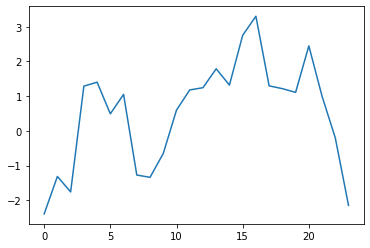

In [72]:
plt.plot(np.mean(error,axis=0));

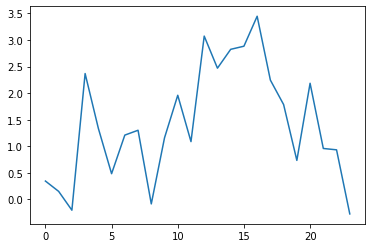

In [73]:
plt.plot(np.percentile(error, 50 ,axis=0));

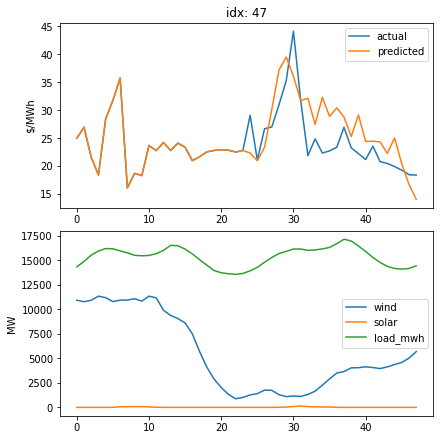

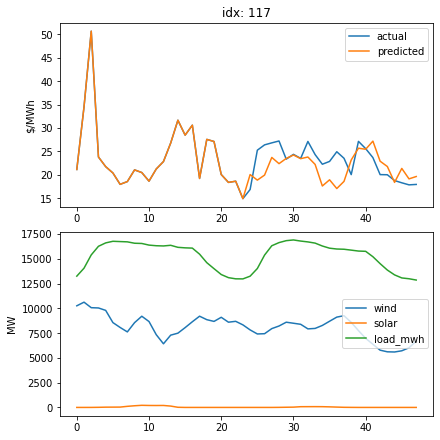

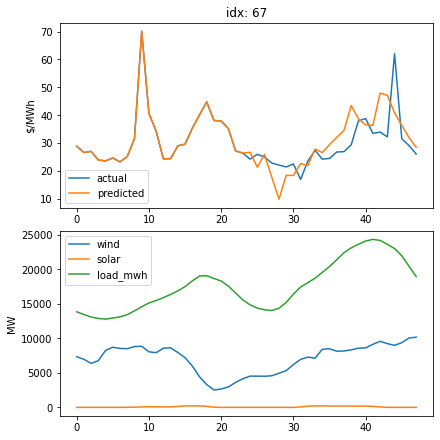

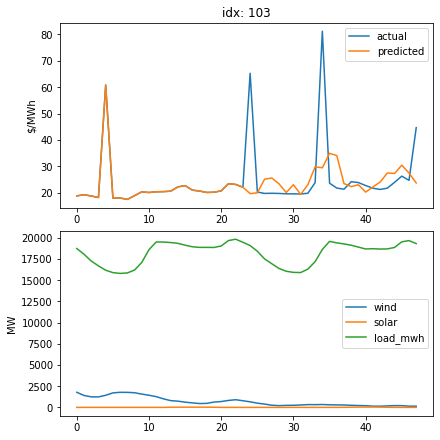

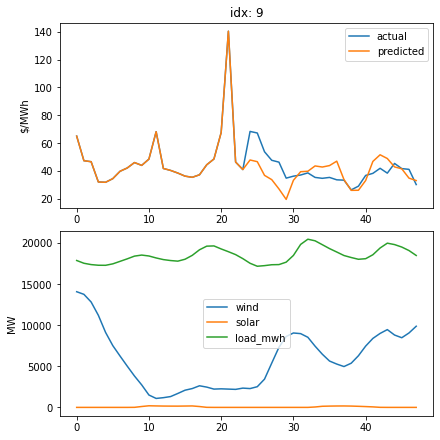

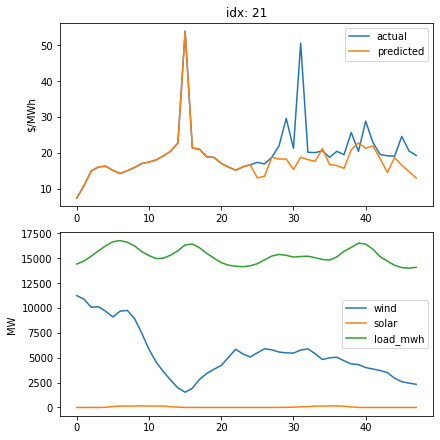

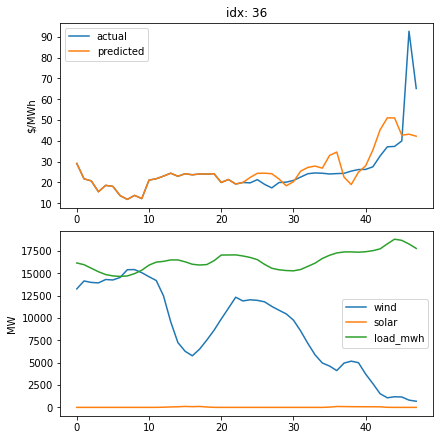

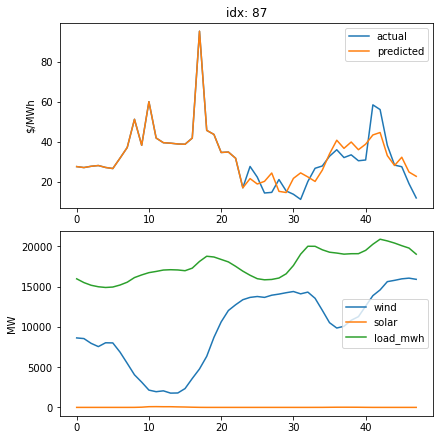

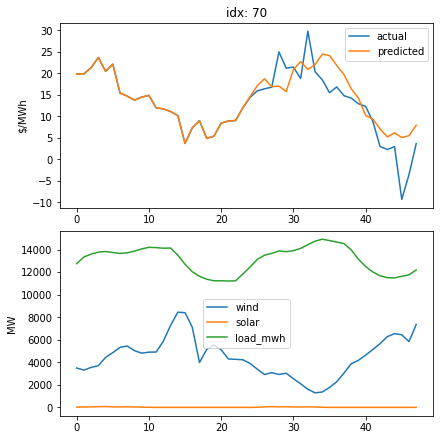

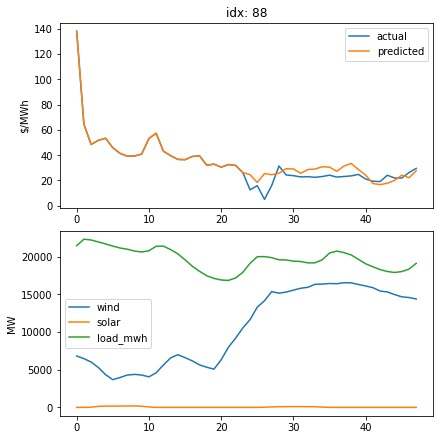

In [74]:
# create some random plots from the last batch of testing data
# to see what the model has learned
N_PLOT = 10

r_idx = np.random.randint(low=0, high=res['label'].shape[0], size=N_PLOT, dtype=int)
for i in r_idx:
    
    hist_future_cols = ['wind', 'solar', 'load_mwh']
    hist_future = res['hist_future'][i,:].cpu().numpy()
    hist_future = np.transpose(hist_future)
    hist_future = (
        hist_future*scaler['sd'][hist_future_cols].values.reshape(1,-1)+
        scaler['means'][hist_future_cols].values.reshape(1,-1)
    )

    hist_future = pd.DataFrame(hist_future, columns=hist_future_cols)

    hist = res['hist'][i,:][0].cpu().numpy()
    
    actual = res['label'][i,:].cpu().numpy()
    actual = np.concatenate([hist, actual])

    predicted = res['output'][i,:].cpu().numpy()
    predicted = np.concatenate([hist, predicted])
    
    comp = pd.DataFrame(
        {'actual':actual, 'predicted':predicted}
    )
    
    fig, axs = plt.subplots(
        ncols=1, 
        nrows=2, 
        figsize=(6, 6),
        constrained_layout=True
    )
    
    comp.plot(ax=axs[0]);
    axs[0].set_ylabel('$/MWh')
    axs[0].set_title(f'idx: {i}');
    hist_future.plot(ax=axs[1]);
    axs[1].set_ylabel('MW')
    plt.show();
    print('=================================================================\n')


## Model serving data testing

* Test model inference on data from the `res` dictionary created above.
* Convert data to json file
* Read in json file
* Test inference on data read from json file

In [75]:
import json
import requests

In [76]:
test_inference_data = {
    'hist_future':res['hist_future'][:1,:,:],
    'hist':res['hist'][:1,:,:],
    'tabular':res['tabular'][:1,:],
}
test_inference_data

{'hist_future': tensor([[[ 0.9148,  0.7847,  0.6926,  0.7068,  0.7605,  0.8062,  0.9102,
            1.1400,  1.3247,  1.5101,  1.4535,  1.4729,  1.2542,  1.1290,
            0.9983,  1.0225,  1.0159,  0.9613,  1.0901,  1.2516,  1.3814,
            1.3562,  1.3166,  1.3242,  1.2301,  1.2955,  1.3232,  1.3573,
            1.2632,  1.2091,  1.0805,  1.2192,  1.3445,  1.4219,  1.5002,
            1.4091,  1.3409,  1.3859,  1.1961,  1.0950,  1.1845,  1.0358,
            0.9165,  1.2330,  1.4686,  1.6058,  1.6497,  1.7391],
          [ 2.8988,  3.0958,  3.2766,  3.0084,  2.0589,  0.8176, -0.4977,
           -0.6384, -0.6384, -0.6384, -0.6384, -0.6384, -0.6384, -0.6384,
           -0.6384, -0.6370, -0.4755, -0.0193,  0.8058,  1.2517,  1.3953,
            1.7227,  1.1554,  2.0649,  2.2974,  1.7657,  1.4220,  0.8695,
            0.1940, -0.3318, -0.6133, -0.6384, -0.6384, -0.6384, -0.6384,
           -0.6370, -0.6370, -0.6370, -0.6384, -0.6384, -0.5244,  0.3096,
            0.7836,  1.3242,  1

In [77]:
model.to(device)
pred_test = model(**test_inference_data)
pred_test

tensor([[ 27.8095,  13.5886,  15.7975,  25.8197,  26.3397,  19.8385,  25.1453,
          13.6878,  -2.2720, -10.2617,  -9.5196,   6.2562,  22.0780,  24.8748,
          37.2395,  38.2462,  37.9141,  41.3714,  49.9201,  47.0176,  34.4107,
          26.8464,  30.5731,  24.9895]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [78]:
type(pred_test)

torch.Tensor

### Covert data to json

In [79]:
inference_data = {
    'hist_future':res['hist_future'][:1,:,:].cpu().tolist(),
    'hist':res['hist'][:1,:,:].cpu().tolist(),
    'tabular':res['tabular'][:1,:].cpu().tolist(),
}

post_data = json.dumps(inference_data)

In [80]:
post_data

'{"hist_future": [[[0.9148439888875586, 0.7846716305326427, 0.692643592473093, 0.7068017521745623, 0.7604908560596864, 0.8061764641685509, 0.9102462359948136, 1.140036573692541, 1.3247494716534605, 1.5100948647213186, 1.4534865526503242, 1.4728506336165947, 1.2541776137600553, 1.1290408895257642, 0.9983090162685563, 1.0225384442112768, 1.0158972455884228, 0.9613080525126549, 1.0901424404490476, 1.251647633332301, 1.3813821104593371, 1.3561796131213268, 1.3165756887330249, 1.3242142834860513, 1.2301427996963927, 1.2955330630598794, 1.3232412140907612, 1.3572986429259104, 1.2632271591362518, 1.2090758472883647, 1.0805090534356767, 1.2191714422644981, 1.3444541269080823, 1.4219104507731648, 1.5001695568893607, 1.4090659347553367, 1.3409024236152745, 1.3858825564125534, 1.1960853708612436, 1.0950321141603798, 1.1844571915875286, 1.0357965147221027, 0.9165225335944341, 1.232989027677616, 1.4686421084819654, 1.60582056648297, 1.649657342740783, 1.7390580934330495], [2.898828360868792, 3.0958

In [81]:
with open('post_data.json', 'w', encoding='utf-8') as f:
    json.dump(inference_data, f, ensure_ascii=False, indent=4)

### Read json data

In [82]:
with open('post_data.json', 'r') as f:
    post_data = f.read()

In [83]:
post_data

'{\n    "hist_future": [\n        [\n            [\n                0.9148439888875586,\n                0.7846716305326427,\n                0.692643592473093,\n                0.7068017521745623,\n                0.7604908560596864,\n                0.8061764641685509,\n                0.9102462359948136,\n                1.140036573692541,\n                1.3247494716534605,\n                1.5100948647213186,\n                1.4534865526503242,\n                1.4728506336165947,\n                1.2541776137600553,\n                1.1290408895257642,\n                0.9983090162685563,\n                1.0225384442112768,\n                1.0158972455884228,\n                0.9613080525126549,\n                1.0901424404490476,\n                1.251647633332301,\n                1.3813821104593371,\n                1.3561796131213268,\n                1.3165756887330249,\n                1.3242142834860513,\n                1.2301427996963927,\n                1.29553306

In [84]:
post_data_loaded = json.loads(post_data) # returns dict
post_data_loaded

{'hist_future': [[[0.9148439888875586,
    0.7846716305326427,
    0.692643592473093,
    0.7068017521745623,
    0.7604908560596864,
    0.8061764641685509,
    0.9102462359948136,
    1.140036573692541,
    1.3247494716534605,
    1.5100948647213186,
    1.4534865526503242,
    1.4728506336165947,
    1.2541776137600553,
    1.1290408895257642,
    0.9983090162685563,
    1.0225384442112768,
    1.0158972455884228,
    0.9613080525126549,
    1.0901424404490476,
    1.251647633332301,
    1.3813821104593371,
    1.3561796131213268,
    1.3165756887330249,
    1.3242142834860513,
    1.2301427996963927,
    1.2955330630598794,
    1.3232412140907612,
    1.3572986429259104,
    1.2632271591362518,
    1.2090758472883647,
    1.0805090534356767,
    1.2191714422644981,
    1.3444541269080823,
    1.4219104507731648,
    1.5001695568893607,
    1.4090659347553367,
    1.3409024236152745,
    1.3858825564125534,
    1.1960853708612436,
    1.0950321141603798,
    1.1844571915875286,
    

In [85]:
# convert data to tensors
for k in post_data_loaded.keys():
    post_data_loaded[k] = torch.asarray(post_data_loaded[k]).to(device)

In [86]:
post_data_loaded

{'hist_future': tensor([[[ 0.9148,  0.7847,  0.6926,  0.7068,  0.7605,  0.8062,  0.9102,
            1.1400,  1.3247,  1.5101,  1.4535,  1.4729,  1.2542,  1.1290,
            0.9983,  1.0225,  1.0159,  0.9613,  1.0901,  1.2516,  1.3814,
            1.3562,  1.3166,  1.3242,  1.2301,  1.2955,  1.3232,  1.3573,
            1.2632,  1.2091,  1.0805,  1.2192,  1.3445,  1.4219,  1.5002,
            1.4091,  1.3409,  1.3859,  1.1961,  1.0950,  1.1845,  1.0358,
            0.9165,  1.2330,  1.4686,  1.6058,  1.6497,  1.7391],
          [ 2.8988,  3.0958,  3.2766,  3.0084,  2.0589,  0.8176, -0.4977,
           -0.6384, -0.6384, -0.6384, -0.6384, -0.6384, -0.6384, -0.6384,
           -0.6384, -0.6370, -0.4755, -0.0193,  0.8058,  1.2517,  1.3953,
            1.7227,  1.1554,  2.0649,  2.2974,  1.7657,  1.4220,  0.8695,
            0.1940, -0.3318, -0.6133, -0.6384, -0.6384, -0.6384, -0.6384,
           -0.6370, -0.6370, -0.6370, -0.6384, -0.6384, -0.5244,  0.3096,
            0.7836,  1.3242,  1

In [87]:
# check prediction
model.to(device)
pred = model(**test_inference_data)
pred

tensor([[ 27.8095,  13.5886,  15.7975,  25.8197,  26.3397,  19.8385,  25.1453,
          13.6878,  -2.2720, -10.2617,  -9.5196,   6.2562,  22.0780,  24.8748,
          37.2395,  38.2462,  37.9141,  41.3714,  49.9201,  47.0176,  34.4107,
          26.8464,  30.5731,  24.9895]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [88]:
# check that the predictions from the json formatted data match the 
# predictions from the test data
pred_test.tolist() == pred.tolist()

True

## Torchserve

In [ ]:
# see for custom handler
# https://pytorch.org/serve/custom_service.html

In [89]:
# https://github.com/pytorch/serve/tree/master/model-archiver#creating-a-model-archive
!torch-model-archiver --model-name pytorch_cnn --version 1.0 --export-path /workspace/models --serialized-file $MLFLOW_MODEL_URI --handler /workspace/src/model_handler.py --force

WARNING - Overwriting /workspace/models/pytorch_cnn.mar ...


see https://github.com/pytorch/serve/blob/master/docs/server.md

To start a torchserve server run the following command in a terminal:

`torchserve --start --model-store /workspace/models --models miso_price=pytorch_cnn.mar`

This will serve a prediction endpoint at predictions/miso_price/ and run your custom service code in the archive (`.mar` file).

In [90]:
# check the status of the torchserve server
# https://github.com/pytorch/serve/blob/master/docs/inference_api.md
!curl http://localhost:8080/ping

{
  "status": "Healthy"
}


In [91]:
req = requests.post(
    "http://localhost:8080/predictions/miso_price", 
    files={'post_data': open('post_data.json', 'r')}
)

In [92]:
req.status_code, req.reason

(200, '')

In [93]:
req.text

'[\n  27.809499273484324,\n  13.588595800500066,\n  15.797504894346801,\n  25.81969817979393,\n  26.339677748916444,\n  19.838464931169185,\n  25.145278277872055,\n  13.687821678847783,\n  -2.271974868476034,\n  -10.26173183360983,\n  -9.519573658937356,\n  6.256155658237239,\n  22.07796066715317,\n  24.874848304042548,\n  37.23950757043206,\n  38.246153096707005,\n  37.914109976727175,\n  41.37139045574117,\n  49.92014166968139,\n  47.01758519028611,\n  34.4106637089542,\n  26.846391889336445,\n  30.57306715391853,\n  24.989463335910376\n]'

In [94]:
# check that the predictions from the api call match the 
# predictions from the test data
all(np.round(pred_test.tolist()[0], 7) == np.round(json.loads(req.text), 7))

True

In [95]:
pd.DataFrame(
    {
        'price_forecast_api':json.loads(req.text),
        'price_forecast_test_data':pred_test.tolist()[0]
    }
)

,price_forecast_api,price_forecast_test_data
0,27.809499,27.809499
1,13.588596,13.588596
2,15.797505,15.797505
3,25.819698,25.819698
4,26.339678,26.339678
5,19.838465,19.838465
6,25.145278,25.145278
7,13.687822,13.687822
8,-2.271975,-2.271975
9,-10.261732,-10.261732


## Save notebook to html

In [96]:
!jupyter nbconvert --to html /workspace/src/build_mlflow_exp.ipynb

[NbConvertApp] Converting notebook /workspace/src/build_mlflow_exp.ipynb to html
[NbConvertApp] Writing 1416650 bytes to /workspace/src/build_mlflow_exp.html
